# Guitar Sound Simulations

In [1]:
import numpy as np
from numpy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.io import wavfile
import simpleaudio
import os
import time
from tqdm import tqdm

# Notes and frequencies

In [2]:
# All notes in the 4th octave according to the equal temperament
ns = np.arange(-9, 3)
frequencies = 440 * 2**(ns/12)
note_names = ["C" ,"C#","D" ,"D#","E" ,"F" ,"F#","G" ,"G#", "A", "A#", "B"]
Notes = {note_names[i]:frequencies[i] for i in range(ns.size)}

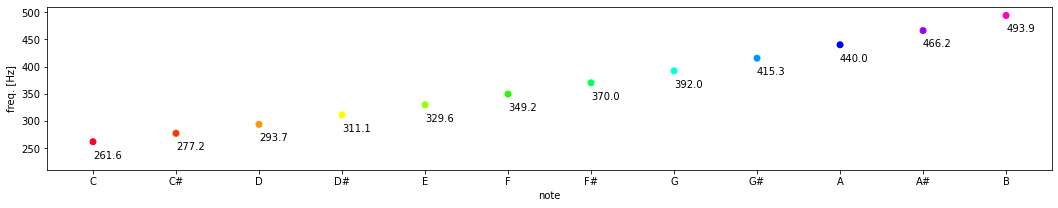

In [3]:
fig, ax = plt.subplots(figsize=(18,3))
plt.xlabel('note')
plt.ylabel('freq. [Hz]')
plt.ylim(210, 510)
plt.scatter(note_names, frequencies, c=frequencies, cmap='gist_rainbow')
for i in range(12):
    ax.annotate('{:.1f}'.format(frequencies[i]), (note_names[i], frequencies[i] - 30))
plt.show()

In [4]:
# Get the freq. of a given note
def freqOf(note):
    '''Function to obtain the frequency of any note'''
    def has_numbers(inputString):
        return any(char.isdigit() for char in inputString)
    if note != 'O': # If the note is not rest symbol
        if has_numbers(note):
            octave = int(note[-1])
            frequency = Notes[note[:-1]]
            frequency = frequency * 2**(octave - 4)
        else:
            frequency = Notes[note]   # 4-th octave by defaut
    else:
            frequency = 0
    return frequency

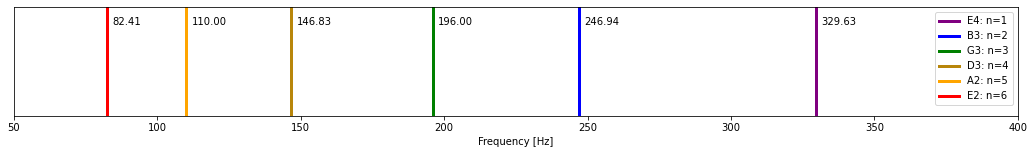

In [5]:
# Get the fundamental frequencies of open guitar strings from n = 1 to 6
openNotes = ['E4', 'B3', 'G3', 'D3', 'A2', 'E2']
freq_opens = np.array([freqOf(note) for note in openNotes])

# Plot
colors = ['purple', 'blue', 'green', 'darkgoldenrod', 'orange', 'red']
fig, ax = plt.subplots(figsize=(18, 2))
plt.yticks([])
plt.xlabel('Frequency [Hz]')
plt.xlim(50, 400)
plt.ylim(-1, 30)
for i in range(6):
    plt.axvline(x = freq_opens[i],  color=colors[i], label= openNotes[i]+': n={}'.format(i+1),linestyle='-', linewidth=3)
    ax.annotate('{:.2f}'.format(freq_opens[i]), (freq_opens[i]+2, 25))
plt.legend(ncol=1)
plt.show()

# Fret positions

$$
\frac{\partial ^2 u}{\partial x^2} = \frac{\mu}{T} \frac{\partial ^2 u}{\partial t ^2} \Leftrightarrow \frac{\partial ^2 u}{\partial x^2} = \frac{1}{c^2} \frac{\partial ^2 u}{\partial t ^2} \Rightarrow \frac{\mu}{T} = \frac{1}{c^2} \Rightarrow c = \sqrt{\frac{T}{\mu}}
$$


$$
c = \lambda f = \sqrt{\frac{T}{\mu}} \Rightarrow 2Lf = \sqrt{\frac{T}{\mu}} \Rightarrow f = \frac{1}{2} \sqrt{\frac{T}{\mu}} \frac{1}{L} \Rightarrow f \propto  \frac{1}{L}
$$


$$
f \rightarrow a\cdot f \Leftrightarrow L \rightarrow \frac{L}{a}
$$

In [6]:
lmax = 0.6477
Ls = []
for fret in range(20):
    a = (2**(fret/12)) # 2**(1/12) = 1.0594630944
    L = lmax/a
    Ls.append(L)

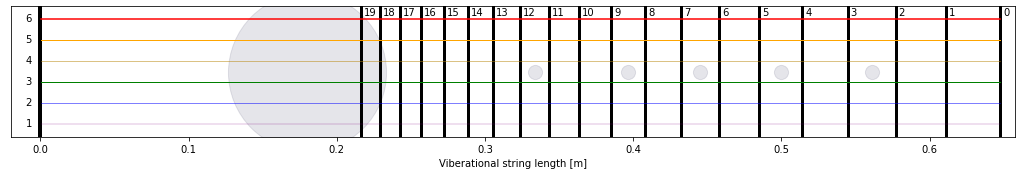

In [7]:
# Visualisation
fig, ax = plt.subplots(figsize=(18, 2.4))
plt.yticks([])
plt.xlabel('Viberational string length [m]')
plt.xlim(-0.02, lmax + 0.01)
plt.ylim(0, 30)
for fret in range(20):
    L = Ls[fret]
    plt.axvline(x = L,  color='k', linestyle='-', linewidth=3)
    ax.annotate('{}'.format(fret), (L+0.002, 28))
    # Fret Markers
    if fret == 3 or fret == 5 or fret == 7 or fret == 9 or fret == 12:
        plt.scatter(L+(Ls[fret-1] - Ls[fret])/2, 15, s=200, color='#000033', alpha=0.1)
# Sound hole
plt.scatter(0.18, 15, s=25000, color='#000033', alpha=0.1)
#  Saddle
plt.axvline(x = 0,  color='k', linestyle='-', linewidth=4)
# Strings
ys = np.linspace(0, 24, 6)
start = 3
lws = [0.5,1, 2,1,2,3]
for i in range(6):
    y = start + ys[i]
    plt.axhline(y = y, xmin=0.03, xmax=0.985,  color=colors[i], linestyle='-', linewidth=lws[i]*0.5)
    ax.annotate('{}'.format(i+1), (0-0.01, y-0.5))
plt.show()

# Tune the open strings

$$
f = \frac{1}{2} \sqrt{\frac{T}{\mu}} \frac{1}{L}
$$

Fixing $L$, we change $T$. String Tension $T$ and linear density $\mu$ for each string are used from an classical guitar from [here](https://nbviewer.org/github/HuangJiaLian/DataBase0/blob/master/uPic/2022_07_12_15_DAddario_Sr_String_Tension_Specifications.pdf).

In [8]:
def get_u(str_num, fret=0):
    '''Function to get the solution of any note on a guitar fret.'''
    global ts, xs, nx, nt, dx, dt, fs, tmax, lmax
    
    # a. Tensions in Newton for 1st to 6th strings: pound -> kg -> N
    # Change the values to tune the guitar
    Ts = np.array([15.3, 11.6, 12.1, 15.6, 15.0, 14.0]) * 0.45359237*9.80665
    # Linear density (kg/m) for 1st to 6th strings
    mus = np.array([0.00002092, 0.00002827, 0.00004679, 0.00010754, 0.00018416, 0.00030632])*0.45359237/0.0254
    
    tmax = 6 # The simulation time
    fs = 44100 # Samples per second(sampling rate)
    nt = int(fs * tmax) # Total sample times
    dt = tmax / nt
    
    # Obtain from fret: https://youtu.be/13iHQJursYc?t=5
    lmax =  25.5 * 0.0254 #  25.5 inch to 0.6477 m
    L = (lmax)/((2**(1/12))**fret)
    ls = 90 # Samples per meter
    nx = int(ls * L) # Total sample positions
    dx = L/nx

    
    idx = str_num
    T = Ts[idx - 1]
    mu = mus[idx - 1]

    # Damp constants
    s0 = 0.3
    s1 = 0.06
    
    C = (T/mu)**0.5
    m = C * dt/dx # The number m should be less than 1 to ensure a stable solution
    if m > 1:
        print('Error')
        exit()
    else:
        print(m)
        
    ts = np.linspace(0, tmax, nt+1, dtype=np.float64)
    xs = np.linspace(0,  L, nx+1, dtype=np.float64)
    u = np.zeros((nt+1, nx+1), dtype=np.float64)
    
    # Initio conditions (Boundary conditions are included as u is 0 everywhere)
    u[0] = np.where(xs < 0.18, -xs/18, xs/47 - 0.01383) # Triangular shape
    u[1] = u[0] # Initio speed is 0
    # Solve 1D wave equation numerically
    for i in range(1, nt):
        for j in range(1, nx):
            u[i+1, j] = (((u[i, j+1] - 2*u[i, j] + u[i, j-1])*T)/(mu*dx**2)  - 2*s0*((u[i, j] - u[i-1, j])/dt)  + s1*((u[i, j+1] -2*u[i,j] + u[i, j-1])-(u[i-1, j+1] -2*u[i-1, j] + u[i-1, j-1]))/(dt*dx**2)) * dt**2 + 2*u[i, j] - u[i-1, j]
    return u

In [9]:
#  Get solution of open strings (fret=0)
u_opens = []
for str_num in [1, 2, 3, 4, 5, 6]:
    u = get_u(str_num=str_num, fret=0)
    u_opens.append(u)

0.8666776128565806
0.6491705259782676
0.5153578144450215
0.3859846077278318
0.28922822980210233
0.21665516367969487


In [10]:
#  Pick up the sound near the guitar hole (around 0.18m)
sound_hole_x = np.logical_and(xs >= 0.11, xs <= 0.24)
u_open_picks = []
for i in range(6):
    u_open_pick = np.sum(u_opens[i][:, sound_hole_x], axis=-1)
    u_open_picks.append(u_open_pick)

In [11]:
# Fast Fourier Transform
freq = rfftfreq(nt, d=dt) # The x axis of FFT
fft_ams = []
for i in range(6):
    X = rfft(u_open_picks[i]) # FFT
    amplitude = np.abs(X)*0.01 # Amplitude of FFT
    fft_ams.append(amplitude)

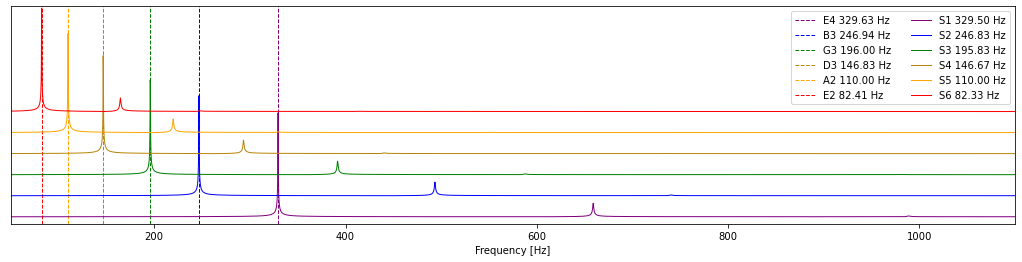

In [12]:
# Frequency Comparsion between the the solutions and the standard notes
plt.figure(figsize=(18, 4))
plt.yticks([])
plt.xlabel('Frequency [Hz]')
# plt.ylabel('Amplitude')
plt.xlim(50, 1100)
plt.ylim(-1, 30)

colors = ['red', 'orange', 'darkgoldenrod', 'green', 'blue', 'purple']
colors.reverse()

# The standard notes and their frequencies
for i, note in enumerate(openNotes):
    f = freqOf(note)
    plt.axvline(x = f,  color=colors[i], label = '{} {:.2f} Hz'.format(note, f), linestyle='--', linewidth=1)

for i in range(6):
    f_m = freq[np.argmax(fft_ams[i])] # The fundamental frequency
    plt.plot(freq, fft_ams[i] + i*3, label='S{} {:.2f} Hz'.format(i+1, f_m), color=colors[i], linewidth=1)
    
# plt.title('The  fundamental frequency: {:.2f} Hz'.format(f_m))
plt.legend(ncol=2)
plt.savefig('fft_compare.png')
plt.savefig('fft_compare.svg')
plt.show()

In [13]:
# Save audios to wave files
amplitude = np.iinfo(np.int16).max # int16 range: [-32767, 32767]
for i in range(6):
    wavfile.write('{}-{}.wav'.format(i+1, 0), fs, (u_open_picks[i]*amplitude*2).astype(np.int16))

# Get all notes on a guitar
$$
f = \frac{1}{2} \sqrt{\frac{T}{\mu}} \frac{1}{L}
$$

Fixing $T$, we change $L$.

In [14]:
for str_num in [1, 2, 3, 4, 5, 6]:
    for fret in tqdm(range(12 +1)):
        # Solve equation
        u = get_u(str_num, fret)
        # Pick up the sound near the guitar hole
        sound_hole_x = np.logical_and(xs >= 0.11, xs <= 0.24)
        u_sum = np.sum(u[:, sound_hole_x], axis=-1)
        # Save wave files
        amplitude = np.iinfo(np.int16).max
        wavfile.write('{}-{}.wav'.format(str_num, fret), fs, (u_sum*amplitude*2).astype(np.int16))    

# Play

In [15]:
def get_envelope(attack=0.1, duration=1, fs=8000):
    ts = np.linspace(0, duration, int(duration*fs) + 1, False)
    ts_attack = ts[ts<attack]
    ts_sustain =  ts[np.logical_and(ts>=attack, ts<(duration ))]
    amplitude_attack = ts_attack/attack
    amplitude_sustain = np.ones_like(ts_sustain)
    amplitude_envelope = np.concatenate([amplitude_attack, amplitude_sustain])
    return ts, amplitude_envelope

In [16]:
def play(str_num, fret):
    _, amplitude_envelope = get_envelope(attack=0.005, duration=tmax, fs=fs)
    a = wavfile.read('{}-{}.wav'.format(str_num, fret))
    simpleaudio.play_buffer((a[1]*amplitude_envelope*4).astype(np.int16), 1, 2, a[0])

In [17]:
ti = 0.2
# Notes
# play(5, 3)
# time.sleep(ti)
# play(4, 0)
# time.sleep(ti)
# play(4, 2)
# time.sleep(ti)
# play(4, 3)
# time.sleep(ti)
# play(3, 0)
# time.sleep(ti)
# play(3, 2)
# time.sleep(ti)
# play(2, 0)
# time.sleep(ti)
# play(2, 1)

# Chord
# play(5, 3)
# time.sleep(ti)
# play(4, 2)
# time.sleep(ti)
# play(3, 0)
# time.sleep(ti)
# play(2, 1)
# time.sleep(ti)
# play(1, 0)
# time.sleep(ti)

play(5, 3)
play(4, 2)
play(3, 0)
play(2, 1)
play(1, 0)

# Music

[Down by the sally gardens](https://nbviewer.org/github/HuangJiaLian/DataBase0/blob/master/uPic/2022_07_12_10_huamei.png)

In [18]:
def playSong():
    ti = 0.4
    #  1
    play(3, 0)
    time.sleep(ti)
    play(3, 2)
    time.sleep(ti)

    #  2
    play(6, 3)
    play(3, 0)
    play(2, 0)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(3, 2)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)

    # 3
    play(6, 2)
    play(3, 2)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)

    #  4
    play(5, 3)
    play(1, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 1)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)

    #  5
    play(6, 3)
    play(2, 3)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(1, 3)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)

    # 6
    play(5, 3)
    play(1, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)

    # 7
    play(6, 3)
    play(3, 2)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(3, 2)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)

    # 8
    play(6, 3)
    play(3, 0)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)

    # 9
    play(6, 3)
    play(1, 3)
    time.sleep(2*ti)
    play(3, 0)
    time.sleep(ti)
    play(3, 2)
    time.sleep(ti)

    # 
    play(6, 3)
    play(3, 0)
    play(2, 0)
    time.sleep(ti)
    play(3, 2)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)

    play(6, 2)
    play(3, 2)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)

    play(5, 3)
    play(1, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 1)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)

    play(6, 3)
    play(2, 3)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(1, 3)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)

    play(5, 3)
    play(1, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)

    play(6, 3)
    play(3, 2)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(3, 2)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)

    play(6, 3)
    play(3, 0)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)

    # 10
    play(6, 3)
    play(1, 3)
    time.sleep(2*ti)
    play(3, 0)
    play(2, 2)
    time.sleep(ti/2)
    play(2, 3)
    time.sleep(ti/2)
    play(1, 3)
    time.sleep(ti)

    # 11
    play(6, 3)
    play(1, 3)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(4, 0)
    play(1, 2)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)

    # 12
    play(5, 3)
    play(1, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(1, 3)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)

    # 13
    play(5, 2)
    play(1, 2)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)
    play(1, 0)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)

    # 14
    play(5, 2)
    play(2, 3)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)
    play(3, 0)
    play(2, 0)
    time.sleep(ti)
    play(3, 2)
    play(2, 1)
    time.sleep(ti/2)
    play(3, 4)
    play(2, 3)
    time.sleep(ti/2)

    # 15
    play(5, 3)
    play(1, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)

    # 16
    play(4, 0)
    play(2, 3)
    time.sleep(ti)
    play(1, 0)
    time.sleep(ti)
    play(1, 3)
    time.sleep(ti)
    play(1, 5)
    time.sleep(ti)

    # 17
    play(6, 3)
    play(1, 3)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)

    # 18
    play(4, 0)
    time.sleep(ti/4)
    play(3, 0)
    time.sleep(ti/4)
    play(2, 3)
    time.sleep(ti/4)
    play(1, 3)
    time.sleep(ti/4)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(3, 2)
    time.sleep(ti)

    # 19 
    play(6, 3)
    play(2, 0)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(3, 2)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)

    # 20 
    play(6, 2)
    play(3, 2)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)

    # 21
    play(5, 3)
    play(1, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 1)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)

    # 22
    play(6, 3)
    play(2, 3)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(1, 3)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)

    # 23
    play(5, 3)
    play(1, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)

    # 24
    play(4, 0)
    play(3, 2)
    play(2, 3)
    time.sleep(ti*2)
    play(3, 4)
    time.sleep(ti/2)
    play(3, 2)
    time.sleep(ti/2)
    play(3, 0)
    time.sleep(ti)

    # 25 
    play(6, 3)
    play(3, 0)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)

    # 26
    play(6, 3)
    play(3, 0)
    play(2, 3)
    play(1, 3)
    time.sleep(ti*4)

    # 27
    play(6, 3)
    play(3, 0)
    play(2, 0)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)

    # 28
    play(4, 0)
    play(3, 2)
    play(2, 3)
    time.sleep(ti)
    play(3, 2)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)
    play(1, 2)
    time.sleep(ti)

    # 29
    play(5, 3)
    play(1, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 1)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)

    # 30 
    play(6, 3)
    play(2, 0)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)

    # 31
    play(6, 3)
    play(2, 0)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)

    # 32
    play(4, 0)
    play(2, 3)
    time.sleep(ti)
    play(1, 0)
    time.sleep(ti)
    play(1, 5)
    time.sleep(ti)
    play(1, 3)
    time.sleep(ti)

    # 33
    play(6, 3)
    play(2, 0)
    play(1, 3)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)

    # 34
    play(6, 3)
    play(1, 3)
    time.sleep(2*ti)
    play(3, 0)
    time.sleep(ti)
    play(3, 2)
    time.sleep(ti)

    # 35
    play(6, 3)
    play(2, 0)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(3, 2)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)

    # 36 
    play(6, 2)
    play(3, 2)
    time.sleep(ti)
    play(4, 0)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)

    # 37
    play(5, 3)
    play(1, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 1)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)

    # 38 
    play(6, 3)
    play(2, 3)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(1, 3)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)

    # 39
    play(5, 3)
    play(1, 0)
    time.sleep(ti)
    play(3, 0)
    time.sleep(ti)
    play(2, 3)
    time.sleep(ti)
    play(2, 0)
    time.sleep(ti)

    # 40
    play(4, 0)
    play(3, 2)
    play(2, 3)
    time.sleep(ti*2)
    play(3, 4)
    time.sleep(ti/2)
    play(3, 2)
    time.sleep(ti/2)
    play(3, 0)
    time.sleep(ti)

    # 41
    play(4, 0)
    time.sleep(ti/4)
    play(3, 0)
    time.sleep(ti/4)
    play(2, 3)
    time.sleep(ti/2)
    play(1, 3)
    time.sleep(ti)


In [19]:
playSong()

# Acknowledgement
Special thanks to [Mr.P Solver](https://www.youtube.com/c/MrPSolver) and Martin Shuppius.


[1] Composing molecular music with carbon, MRS Communications, 2015, doi: 10.1557/mrc.2015.9 <br/>
[2] [Youtube, Martin Shuppius - Physical modelling of guitar strings (ADC'17)](https://www.youtube.com/watch?v=sxt5rxF_PdI)<br/>
[3] [Daddario, All about string tension](https://www.daddario.com/the-lesson-room/guitar/acoustic-guitar/care/all-about-string-tension/)<br/>
[4] [Daddario, Ej45-Pro-Arte-Nylon-Normal-Tension](https://www.daddario.com/products/guitar/classical-guitar/pro-arte-nylon/ej45-pro-arte-nylon-normal-tension/)<br/>
[5] [Measuring String Tension, July 2006, Rod Cross, Physics Department, University of Sydney, Sydney, Australia](http://www.physics.usyd.edu.au/~cross/StringTension.pdf)<br/>
[6] [A complete technical reference for fretted instrument string tensions](https://www.daddario.com/globalassets/pdfs/accessories/tension_chart_13934.pdf) <br/>
[7] [Youtube: I Generated Guitar Audio in python using NUMBA, Mr.P Solver](https://www.youtube.com/watch?v=MavAU3adGk4&t=75s) <br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>